# Tests for QuTiP's SME solver against analytical solution for oscillator squeezing

Denis V. Vasilyev

1 August, 16 August 2013

Minor edits by Robert Johansson 

5 August, 6 August 2013

Edits by Eric Giguere to fit Pull request #815 on Stochastic code

March 2018

We solve the stochastic master equation for an oscillator coupled to a 1D field as discussed in [1]. There is a deterministic differential equation for the variances of the oscillator quadratures $\langle\delta X^2\rangle$ and $\langle\delta P^2\rangle$. This allows for a direct comparison between the numerical solution and the exact solution for a single quantum trajectory.

In this section we solve SME with a single Wiener increment: 
## $\mathrm{d}\rho = D[s]\rho\mathrm{d}t + H[s]\rho \mathrm{d}W + \gamma D[a]\rho\mathrm{d}t$

The steady state solution for the variance $V_{\mathrm{c}} = \langle X^2\rangle - \langle X\rangle^2$ reads

$V_{\mathrm{c}} = \frac1{4\alpha^{2}}\left[\alpha\beta - \gamma + \sqrt{(\gamma-\alpha\beta )^{2} + 4\gamma \alpha^2}\right]$

where $\alpha$ and $\beta$ are parametrizing the interaction between light and the oscillator such that the jump operator is given by $s = \frac{\alpha+\beta}2 a + \frac{\alpha-\beta}2 a^{\dagger}$

[1] D. V. Vasilyev, C. a. Muschik, and K. Hammerer, Physical Review A 87, 053820 (2013). <a href="http://arxiv.org/abs/1303.5888">arXiv:1303.5888</a>

# Implementation of Milstein method for homodyne detection

It is easy to implement the Milstein method [2] for a single Wiener increment using the given QuTiP infrastructure. For a stochastic differential equation $\mathrm{d}\rho = a(\rho)\mathrm{d}t + b(\rho) \mathrm{d}W\quad$ the Milstein scheme gives:

$\Delta \rho = a(\rho_n) \Delta t + b(\rho_n) \Delta W_n + \frac{1}{2} b(\rho_n) b'(\rho_n) \left( (\Delta W_n)^2 - \Delta t \right)$

The derivative can be calculated explicitly which is done below for a homodyne detection stochastic term.

[2] G. N. Milstein, Teor. Veroyatnost. i Primenen. 19, 583–588 (1974).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *
from numpy import log2, cos, sin
from scipy.integrate import odeint
from qutip.cy.spmatfuncs import cy_expect_psi, spmv

In [3]:
th = 0.1 # Interaction parameter
alpha = cos(th)
beta = sin(th)
gamma = 1

# Exact steady state solution for Vc
Vc = (alpha*beta - gamma + sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha**2))/(4*alpha**2)

#********* Model ************
NN = 200
tlist = linspace(0,5,NN)
Nsub = 10
N = 10
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/sqrt(2)
H = Id
c_op = [sqrt(gamma)*a]
sc_op = [s]
e_op = [x, x*x]
rho0 = fock_dm(N,0) #initial vacuum state

In [4]:
# Solution of the differential equation for the variance Vc
y0 = 0.5
def func(y, t):
    return -(gamma - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gamma
y = odeint(func, y0, tlist)

# Righthand side for the Milstein method for a homodyne detection scheme
def rhs_milstein(L, rho_t, t, A_ops, dt, dW, d1, d2, args):
    drho_t = spmv(L.data,
              L.indices,
              L.indptr, rho_t) * dt
    
    A = A_ops[0]
    M = A[0] + A[3]
    e1 = cy_expect_rho_vec(M, rho_t)
    d1_vec = spmv(A[7].data, A[7].indices, A[7].indptr, rho_t)
    
    d2_vec = spmv(M.data, M.indices, M.indptr, rho_t)
    d2_vec2 = spmv(M.data, M.indices, M.indptr, d2_vec)
    e2 = cy_expect_rho_vec(M, d2_vec)
    return rho_t + drho_t + d1_vec*dt + (d2_vec - e1*rho_t)*dW[0,0] + \
           0.5 * (d2_vec2 - 2*e1*d2_vec + (-e2 + 2*e1*e1)*rho_t)*(dW[0,0]*dW[0,0] - dt)
    
#The rhs option of smesolve, 

In [5]:
# Solution for the expectation values
sol = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
               nsubsteps=Nsub, method='homodyne', solver='euler', store_measurement=True)

Total run time:   0.11s


In [6]:
#sol_mil = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
#                   nsubsteps=Nsub, method='homodyne', rhs=rhs_milstein, noise=sol.noise)

In [7]:
#Built-in Milstein with single jump operator
sol_mil_native = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='milstein', noise=sol.noise)

Total run time:   0.11s


## Variance $V_{\mathrm{c}}$ as a function of time

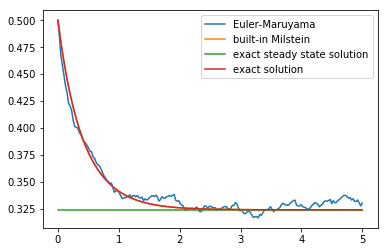

In [8]:
fig, ax = subplots()

ax.plot(tlist,sol.expect[1] - abs(sol.expect[0])**2, label='Euler-Maruyama')
#ax.plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
ax.plot(tlist,sol_mil_native.expect[1] - abs(sol_mil_native.expect[0])**2, label='built-in Milstein')
ax.plot(tlist,Vc*ones(NN), label='exact steady state solution')
ax.plot(tlist,y, label="exact solution")
ax.legend();

## Deviation from exact solution

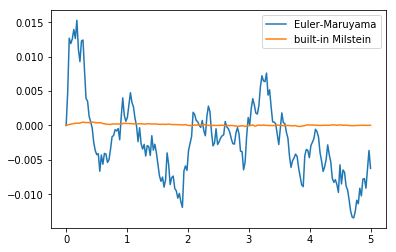

In [9]:
fig, ax = subplots()

ax.plot(tlist, y.T[0] - (sol.expect[1] - abs(sol.expect[0])**2), label='Euler-Maruyama')
#ax.plot(tlist, y.T[0] - (sol_mil.expect[1] - abs(sol_mil.expect[0])**2), label='Milstein')
ax.plot(tlist, y.T[0] - (sol_mil_native.expect[1] - abs(sol_mil_native.expect[0])**2), label='built-in Milstein')
ax.legend();

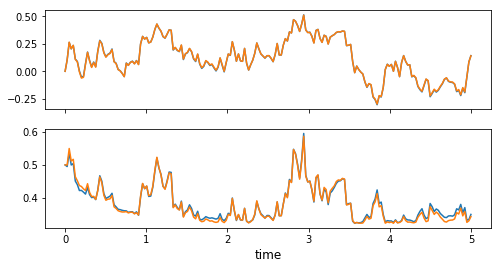

In [10]:
plot_expectation_values([sol,sol_mil_native]);
ax.legend()

## Norm of the density matrix

Here we calculate $|\rho|-1$ which should be zero ideally.

In [11]:
#Solution for the density matrix
sol2 = smesolve(H, rho0, tlist, c_op, sc_op, [], solver="euler",
                nsubsteps=Nsub, method='homodyne', noise=sol.noise, options=Odeoptions(average_states=False))

Total run time:   0.41s


In [12]:
sol2_mil = smesolve(H, rho0, tlist, c_op, sc_op, [], solver="milstein",
                    nsubsteps=Nsub, method='homodyne', noise=sol.noise,
                    options=Odeoptions(average_states=False))

Total run time:   0.44s


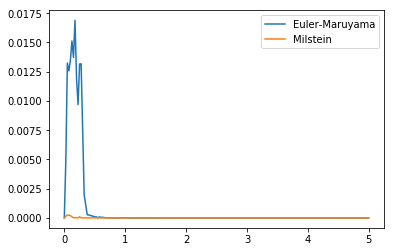

In [13]:
fig, ax = subplots()

ax.plot(tlist,array([sol2.states[0][n].norm() - 1 for n in range(NN)]), label='Euler-Maruyama')
ax.plot(tlist,array([sol2_mil.states[0][n].norm() - 1 for n in range(NN)]), label='Milstein')
ax.legend()

# Milstein method with multiple Wiener increments

In this section we solve the following SME:
## $\mathrm{d}\rho = D[s]\rho\mathrm{d}t + \sqrt{1-\epsilon}H[s]\rho \mathrm{d}W_1 + \sqrt{\epsilon}H[is]\rho \mathrm{d}W_2 + \gamma D[a]\rho\mathrm{d}t$
Analytical results can be found in [1].

We follow [3] in implementation of the Milstein scheme.

Stochastic equation is defined as

$dX^i = a^i(X)dt + \sum_{j=1}^M b^{i,j}(X)dW^j$

It is convenient to define a differential operator as follows

$L^j = \sum_{k=1}^N b^{k,j}\frac{\partial}{\partial x^k}$

Then the numerical scheme is

##$Y^i_{n+1} = Y^i_n + a^i\Delta t + \sum_{j=1}^M b^{i,j}(X)\Delta W^j_n + \sum_{j_1,j_2=1}^M L^{j_1}b^{i,j_2} I_n(j_1,j_2)$

where $I_n(j_1,j_2) = \int_{t_n}^{t_{n+1}}\int_{t_n}^{s_1}dW_{s_2}^{j_1}dW_{s_1}^{j_2}$

## Commutative noise

An impotant case is the commutative noise which means $L^{j_1}b^{k,j_2} = L^{j_2}b^{k,j_1}$. For the homodyne detection it means that the jump operators for different stochastic terms commute. In this case we have

$I_n(j_1,j_2) = I_n(j_2,j_1) = \frac12\Delta W^{j_1}_n \Delta W^{j_2}_n$

Evaluation of the derivatives $L^j$ for homodyne scheme provides us with the numerical scheme implemented below. We also have used the assumption of the commutative noise. The smesolve routine has to be modified. It should provide all the A_ops to the rhs function.

[1] D. V. Vasilyev, C. a. Muschik, and K. Hammerer, Physical Review A 87, 053820 (2013). <a href="http://arxiv.org/abs/1303.5888">arXiv:1303.5888</a>

[3] S. Cyganowski, L. Gruene, and P. E. Kloeden, MAPLE for Stochastic Differential Equations.

In [14]:
th = 0.1
alpha = cos(th)
beta = sin(th)
gamma = 1
eps = 0.3

VcEps = ((1-2*eps)*alpha*beta - gamma + \
         sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha*((1-eps)*alpha + eps*beta)))/(4*(1-eps)*alpha**2)
UcEps = (-(1-2*eps)*alpha*beta - gamma + \
         sqrt((gamma-alpha*beta)**2 + 4*eps*beta*gamma*(beta-alpha)))/(4*eps*beta**2)

NN = 200
tlist = linspace(0,3,NN)
Nsub = 20
N = 10
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/sqrt(2)
H = Id
c_op = [sqrt(gamma)*a]
sc_op = [sqrt(1-eps)*s, sqrt(eps)*1j*s]
e_op = [x, x*x]
rho0 = fock_dm(N,0)
y0 = 0.5

In [15]:
def func(y, t):
    return -(gamma - (1-2*eps)*alpha*beta)*y - 2*(1-eps)*alpha*alpha*y*y + 0.5*(gamma + eps*beta*beta)
y = odeint(func, y0, tlist)

def funcZ(z, t):
    return -(gamma + (1-2*eps)*alpha*beta)*z - 2*eps*beta*beta*z*z + 0.5*(gamma + (1-eps)*alpha*alpha)
z = odeint(funcZ, y0, tlist)

In [16]:
#Built-in taylor for multiple stochastic increments
sol_taylor = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='taylor1.5', 
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   3.90s


In [17]:
sol = smesolve(H, rho0, tlist, c_op, sc_op, e_op, solver="euler", noise=sol_taylor.noise,
               nsubsteps=Nsub, method='homodyne', store_measurement=True,
               options=Odeoptions(store_states=True, average_states=False))

Total run time:   0.61s


In [18]:
#Built-in Milstein for multiple stochastic increments
sol_mil = smesolve(H, rho0, tlist, c_op, sc_op, e_op, solver="milstein",
                   nsubsteps=Nsub, method='homodyne', noise=sol_taylor.noise,
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   0.85s


## Variance $V_{\mathrm{c}}$ as a function of time

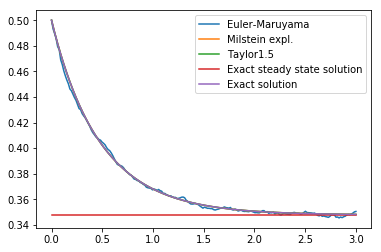

In [19]:
fig, ax = subplots()

ax.plot(tlist,sol.expect[1]-sol.expect[0]*sol.expect[0].conj(), label='Euler-Maruyama')
ax.plot(tlist,sol_mil.expect[1]-sol_mil.expect[0]*sol_mil.expect[0].conj(), label='Milstein expl.')
ax.plot(tlist,sol_taylor.expect[1]-sol_taylor.expect[0]*sol_taylor.expect[0].conj(), label='Taylor1.5')
ax.plot(tlist,VcEps*ones(NN), label='Exact steady state solution')
ax.plot(tlist,y, label='Exact solution')

ax.legend();

## Deviation from exact solution

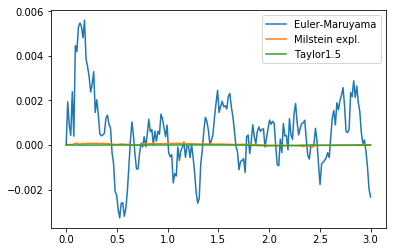

In [20]:
fig, ax = subplots()

ax.plot(tlist, y.T[0] - (sol.expect[1] - abs(sol.expect[0])**2), label='Euler-Maruyama')
ax.plot(tlist, y.T[0] - (sol_mil.expect[1] - abs(sol_mil.expect[0])**2), label='Milstein expl.')
ax.plot(tlist, y.T[0] - (sol_taylor.expect[1] - abs(sol_taylor.expect[0])**2), label='Taylor1.5')

ax.legend();

##Norm of the density matrix

Here we calculate $|\rho|-1$ which should be zero ideally.

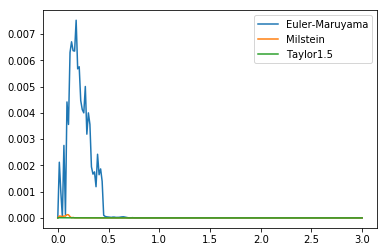

In [21]:
fig, ax = subplots()

ax.plot(tlist,array([sol.states[0][n].norm() - 1 for n in range(NN)]), label='Euler-Maruyama')
ax.plot(tlist,array([sol_mil.states[0][n].norm() - 1 for n in range(NN)]), label='Milstein')
ax.plot(tlist,array([sol_taylor.states[0][n].norm() - 1 for n in range(NN)]), label='Taylor1.5')

ax.legend()

### Software versions

In [22]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+76c6ebda
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.3
Number of CPUs,1
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
